In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from os import listdir
from os.path import join

import deepcoloring as dc

%matplotlib inline
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
!wget https://www.dropbox.com/s/giwn4yl2i85htkw/ecoli_model.t7 -O model.t7

--2018-07-30 11:09:27--  https://www.dropbox.com/s/giwn4yl2i85htkw/ecoli_model.t7
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/giwn4yl2i85htkw/ecoli_model.t7 [following]
--2018-07-30 11:09:27--  https://www.dropbox.com/s/raw/giwn4yl2i85htkw/ecoli_model.t7
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6fe163539a717a605d1260d1b4.dl.dropboxusercontent.com/cd/0/inline/AMpJwR7vjSkdJEI_N9iWpLu5yEJ-6g-Tf5je8xuqszIBgjUaSphCXxM4ddKfoK77j-h0bm50cKCG2Wf3Nc7pk-AcW3b0KmsV1BTWurgx78_IihZGYZMkl0g5SezfIffYibSVJMI_0E_IoRhYyrK5XQGrd18EOMohl6rG5tZkFt9g09RInFWieBd4TTg8tmLSuvw/file [following]
--2018-07-30 11:09:27--  https://uc6fe163539a717a605d1260d1b4.dl.dropboxusercontent.com/cd/0/inline/AMpJwR7vjSkdJEI_N9iWpLu5yEJ-6g-Tf5je8xuqsz

In [53]:
net = dc.EUnet(1,6,k=2,s=4,depth=3,l=1, padding=0, use_dropout=True).to(device)
net.load_state_dict(torch.load("model.t7"))

(<matplotlib.figure.Figure at 0x7fd32e3288d0>,
 <matplotlib.figure.Figure at 0x7fd2850e13d0>)

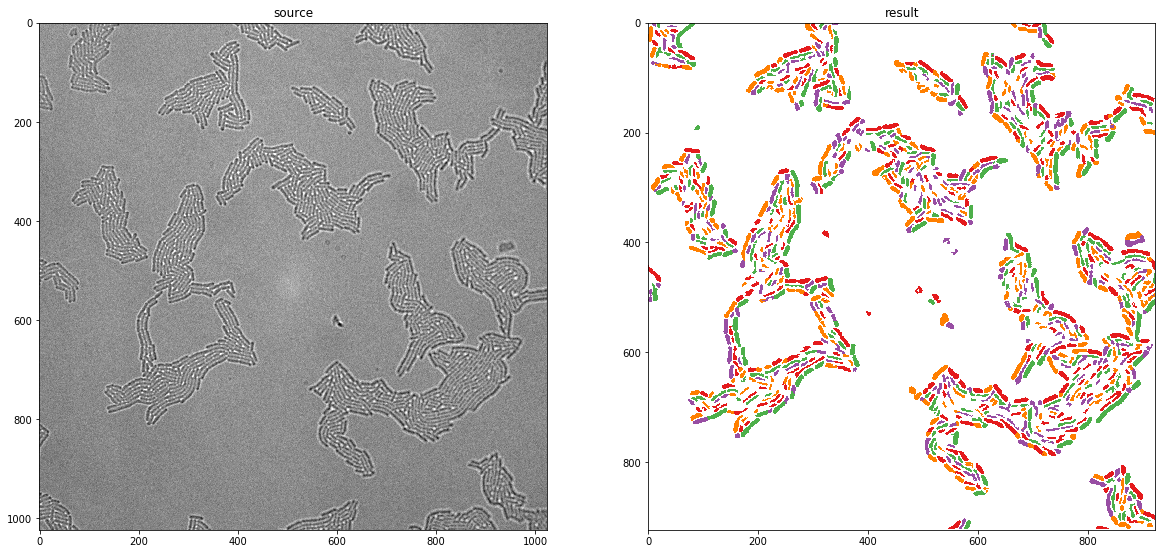

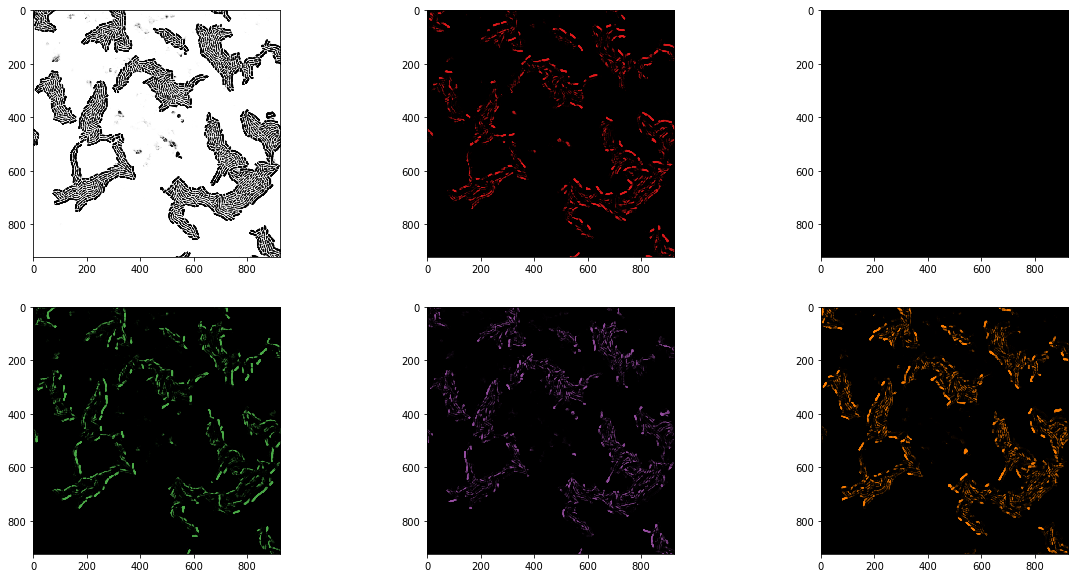

In [54]:
from skimage.io import imread
xo = imread("../images/ecoli31_rgb.png")[:,:,0]

x = dc.normalize(128., 128., )(xo, True)
x = np.expand_dims(x, 0)

vx = torch.from_numpy(np.expand_dims(x, 0)).float().to(device)
p = net(vx)
p_numpy = p.detach().cpu().numpy()[0]
dc.visualize(xo,p_numpy,40,draw_text=False)